# CPSC 330 Lecture 8

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements (5 min)
- Dataset of the week 
- Confusion matrices (5 min)
- Precision, recall, F1 score (10 min)
- Precision-recall curves (10 min)
- Break (5 min)
- ROC curves (10 min)
- Addressing class imbalance (20 min)
- Stratified splits (5 min)
- CV with custom scores, hyperparameter optimization (5 min)
- This week - summary (5 min)

Piazza:

- True/False questions

## Announcements

- Per the [poll on Piazza](https://piazza.com/class/kb2e6nwu3uj23?cid=269), I will start archiving/posting the Zoom chats, but to Canvas only (not publicly). 
  - This should happen automatically from now on. 
  - If you don't want your name archived on Canvas, you can change your name on Zoom. 
  - But if you don't care, I do like knowing who you are! 
  - Also, I didn't realize I could enable audio transcripts, so those are enabled gong forward. There should now be a "CC" button on the videos and I think they are also searchable. 
- hw4 posted, due Monday at 11:59pm
  - A reminder that you need to form groups separately for each assignment on Canvas - please do that before the deadline!
- The midterm will be on Thu Oct 22 in class
  - 75-minute Canvas quiz in the 80-minute window
  - Open book, no invigilation, questions in shuffled order
  - Probably the "you can't go back" restriction, which is super annoying but makes cheating more difficult 
  - I'm thinking mostly short-answer questions
  - Will cover up to Oct 15 lecture (will not cover Oct 20 lecture)
  - Last year's (in-person) midterm posted at https://github.com/UBC-CS/cpsc330/tree/master/exams/2019W2
  - I will post the solutions to last year's midterm on Canvas

## Learning objectives

- Appropriate select between different classification scoring metrics (accuracy, precision, recall, F1 score, ROC AUC) given a problem.
- Explain why accuracy is not always the best metric to optimize.
- Interpret a confusion matrix. 
- Interpret an ROC curve and explain why a higher area under the curve is better.
- Given a problem, determine when it makes sense to alter the probability threshold and/or use the `class_weight` hyperparameter in sklearn.
- Explain how stratified splitting differs from standard splitting.
- Use hyperparameter optimization tools in scikit-learn to optimize scores other than accuracy.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import normalize, scale, Normalizer, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, plot_confusion_matrix, plot_precision_recall_curve, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [2]:
plt.rcParams['font.size'] = 16

## Dataset of the week (5 min)

- Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.
- For confidentially reasons, it only provides transformed features with PCA.
  - So we don't need to worry about categorical features this time.

In [3]:
cc_df = pd.read_csv('data/creditcard.csv', encoding='latin-1')
df_train, df_test = train_test_split(cc_df, test_size=0.15, random_state=123)

In [4]:
df_train.shape

(242085, 31)

In [5]:
X_train = df_train.drop(columns=['Class'])
y_train = df_train['Class']

X_test = df_test.drop(columns=['Class'])
y_test = df_test['Class']

In [6]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
113834,73222.0,-1.047911,0.264798,2.882793,1.050493,-1.754437,1.013074,-1.216518,0.993989,-0.289283,...,-0.374125,-0.392708,-0.197803,-0.109727,0.396181,0.181980,-0.065889,0.328321,0.089068,12.00
209720,137676.0,1.862475,-0.187619,-1.762891,0.300562,0.274679,-0.482736,0.026326,-0.034559,0.755427,...,-0.035498,-0.157633,-0.394398,0.168381,0.589022,-0.118405,-0.144933,-0.023933,-0.014421,69.32
6086,6942.0,1.475676,-0.082584,-0.176180,-0.551063,-0.255257,-1.112522,-0.028757,-0.549704,-0.061398,...,0.128606,0.033541,0.348765,-0.215062,0.059112,0.866292,-0.106655,-0.046937,-0.004705,15.00
15352,26742.0,0.028552,-2.235673,0.517263,0.642202,-1.330937,1.093816,-0.222273,0.376028,0.885882,...,0.932355,0.196759,-0.399784,-0.342213,-0.203934,-0.255216,0.896698,-0.107922,0.091284,549.81
201339,133843.0,1.964985,-0.418204,-0.380086,0.428730,-0.753728,-0.668689,-0.557784,-0.048365,1.359894,...,-0.238540,0.216086,0.751400,0.136596,-0.086692,-0.173467,-0.235863,0.030625,-0.036667,19.78


In [7]:
y_train.head()

113834    0
209720    0
6086      0
15352     0
201339    0
Name: Class, dtype: int64

In [ ]:
X_train.info()

- At this point we would want to think more carefully about the Time and Amount variables.
- We could scale Amount, but do we want to scale Time?
- More on time series coming later in the course.

## Confusion matrices (5 min)

In [8]:
dummy = DummyClassifier(strategy='prior')
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

fit_time       0.032059
score_time     0.002829
test_score     0.998294
train_score    0.998294
dtype: float64

Holy cow! `DummyClassifier` is getting 99.8% accuracy!!

In [9]:
y_train.value_counts()

0    241672
1       413
Name: Class, dtype: int64

- We have MANY non-fraud transactions and only a tiny handful of fraud transactions.
- So, what is a good accuracy here? 99.9%? 99.99%?
- Or, maybe accuracy is not a meaningful measure anymore.
- Today's class is all about this issue.

In [10]:
pipe_lr = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

In [11]:
pd.DataFrame(cross_validate(pipe_lr, X_train, y_train, return_train_score=True)).mean()

fit_time       1.435038
score_time     0.019517
test_score     0.999219
train_score    0.999220
dtype: float64

- This seems slightly better than `DummyClassifier`.
- But can it really identify fraudulent transactions?
- Today we're going to cover some new tools.
- These are a bit easier to deal with if we have an explicit validation set instead of using cross-validation.
- Since our dataset is quite large, we can do this without worrying too much.
  - Let's do an 80-20 split. 
  - We can do this with `train_test_split` again, or just manually since the original `train_test_split` already shuffled the order

In [12]:
X_train_fold = X_train[len(X_train)//5:]
y_train_fold = y_train[len(y_train)//5:]

X_valid_fold = X_train[:len(X_train)//5]
y_valid_fold = y_train[:len(y_train)//5]

or

In [13]:
X_train_fold, X_valid_fold, y_train_fold, y_valid_fold = train_test_split(X_train, y_train, test_size=0.2, random_state=123)

- Note my naming convention: `X_train` is everything except `X_test`, whereas `X_train_fold` is a subset of `X_train`.
- The first thing we're going to introduce is the _confusion matrix_:

In [14]:
pipe_lr.fit(X_train_fold, y_train_fold);

Train:

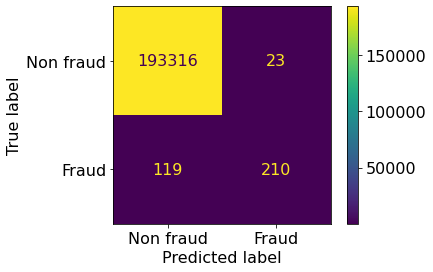

In [15]:
plot_confusion_matrix(pipe_lr, X_train_fold, y_train_fold, display_labels=['Non fraud', 'Fraud']);

Validation:

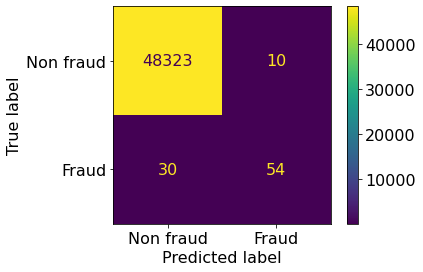

In [16]:
cm_plot = plot_confusion_matrix(pipe_lr, X_valid_fold, y_valid_fold, display_labels=['Non fraud', 'Fraud']);
cm_plot;

In [17]:
cm = confusion_matrix(y_valid_fold, pipe_lr.predict(X_valid_fold))
cm

array([[48323,    10],
       [   30,    54]])

One could imagine doing this separately with 5 folds and averaging, but we're not going to bother.

**Caution**: 

- scikit-learn's convention is to have true label as the rows, predicted as the columns. 
- Others do it the other way around, e.g. the [confusion matrix Wikipedia article](https://en.wikipedia.org/wiki/Confusion_matrix). 

#### Let's understand confusion matrix

Using the sklearn convention:

|   X   | predict negative | predict positive |
|------|----------|-------|
| negative example | True negative (TN) | False positive (FP)|
| positive example | False negative (FN) | True positive (TP) |

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

#### Confusion matrix for multi-class: 

- We will talk about multi-class classification later.
- But for now, FYI we can still compute a confusion matrix, e.g.

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_confusion_matrix_001.png)

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Precision, recall, F1 score (10 min)

#### Accuracy does not tell the whole story!

- Accuracy is misleading when we have class imbalance. 
- We need other metrics to evaluate our models. 
- We'll first discuss model evaluation.
- And then what can be done about class imbalance.
- We need to be proactive here and not blindly call `.score()` or `cross_val_score()` without thinking about metrics.

#### Precision and recall

Recall: how many of the actual positive examples did you identify?

Precision: of the positive examples you identified, how many were real?

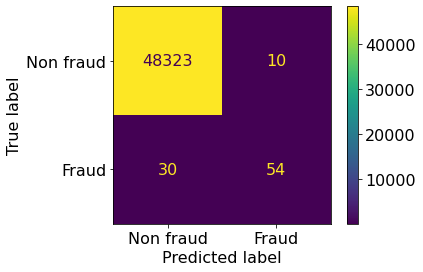

In [18]:
cm_plot.plot();

Recall = TP/(TP + FN) 

In [19]:
54/(30+54)

0.6428571428571429

^ That is how many of the frauds we caught.

Precision = TP/(TP + FP)

In [20]:
54/(10+54)

0.84375

^ Of the frauds we "caught", that many were actual frauds.

See the [MDS terminology document](https://ubc-mds.github.io/resources_pages/terminology/) for related terms like sensitivity, specificity, Type I error, Type II error, etc.

#### Which metric do we care about?

- Of course we'd like to have high precision and recall (more on this later).
- But the balance depends on our domain.
- For credit card fraud detection, recall is really important (catching frauds), precision is less important (reducing false positives).

#### F1 score

- The F1 score is a metric that "averages" precision and recall (not exactly the average, see [here](https://en.wikipedia.org/wiki/F1_score)).
- If both precision and recall go up, the F1 score will go up, so in general we want this to be high.
- Sometimes we need a single score to maximize, e.g. when doing hyperparameter tuning via `RandomizedSearchCV`.
- Accuracy is often a bad choice.
- Later today we'll see another good choice (ROC AUC).

There are a bunch of functions in sklearn to make life easier:

In [21]:
print(classification_report(y_valid_fold, pipe_lr.predict(X_valid_fold), target_names=("Not Fraud", "Fraud")))

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     48333
       Fraud       0.84      0.64      0.73        84

    accuracy                           1.00     48417
   macro avg       0.92      0.82      0.86     48417
weighted avg       1.00      1.00      1.00     48417



- Note that the scores depend on which one you consider the "positive class". 
- If non-fraud is the case you care about, then your precision and recall are very close to 100%
  - But not exactly 100%, see below

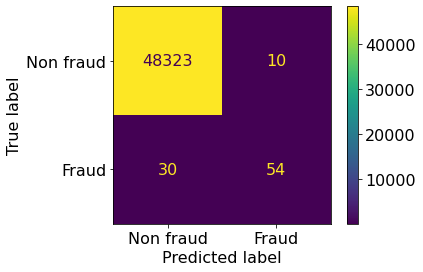

In [22]:
cm_plot.plot();

In [23]:
print(classification_report(y_valid_fold, pipe_lr.predict(X_valid_fold), target_names=("Not Fraud", "Fraud"), digits=4))

              precision    recall  f1-score   support

   Not Fraud     0.9994    0.9998    0.9996     48333
       Fraud     0.8438    0.6429    0.7297        84

    accuracy                         0.9992     48417
   macro avg     0.9216    0.8213    0.8647     48417
weighted avg     0.9991    0.9992    0.9991     48417



Evaluation metrics cheat sheet (created by Varada Kolhatkar):

<img src='img/evaluation-metrics.png' width="800"/>

### Q&A

(Pause for Q&A)

<br><br><br><br>

## Precision-recall curves (10 min)

- What if you care about certain types of mistakes more than others?
- In the fraud detection example, you want to be conservative and bias the model towards predicting "positive".
- We said earlier that `predict` returns 1 when `predict_proba`'s probabilities is above 0.5 for the positive class.
- Key idea: what if we threshold the probability at a different values?

In [24]:
precision_score(y_valid_fold, pipe_lr.predict(X_valid_fold))

0.84375

In [25]:
recall_score(y_valid_fold, pipe_lr.predict(X_valid_fold))

0.6428571428571429

We could get these predictions by thresholding the probabilities instead:

In [26]:
preds = pipe_lr.predict_proba(X_valid_fold)[:,1] > 0.5
recall_score(y_valid_fold, preds)

0.6428571428571429

But in that case... what if we change the threshold?

In [27]:
recall_score(y_valid_fold, pipe_lr.predict_proba(X_valid_fold)[:,1] > 0.8)

0.5595238095238095

- Increasing the threshold means a higher bar for predicting fraud
- So our recall goes down (the precision would normally go up, but not always - see note below)

Likewise we could use a low threshold to get high recall (but while sacrificing precision)

In [29]:
recall_score(y_valid_fold, pipe_lr.predict_proba(X_valid_fold)[:,1] > 0.1)

0.7619047619047619

In [30]:
precision_score(y_valid_fold, pipe_lr.predict_proba(X_valid_fold)[:,1] > 0.1)

0.7710843373493976

- A precision-recall curve does this computation for a grid of possible thresholds and shows the results in a plot:

In [31]:
from sklearn.metrics import plot_precision_recall_curve

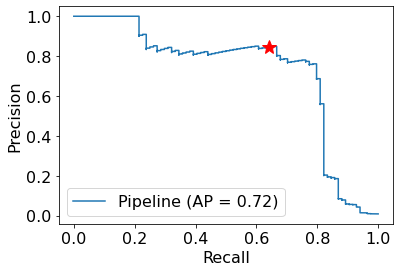

In [32]:
plot_precision_recall_curve(pipe_lr, X_valid_fold, y_valid_fold);
plt.plot(recall_score(y_valid_fold, pipe_lr.predict(X_valid_fold)), precision_score(y_valid_fold, pipe_lr.predict(X_valid_fold)), '*r', markersize=15);

- The threshold is not shown here, but it's going from 1 (upper-left) too 0 (lower right).
- The red star is the threshold 0.5.
- It's bumpy because changing the threshold affects some discrete number of examples.
- The top-right would be a perfect classifier (precision = recall = 1).
- It seems like there might be some good compromises here at precision = 0.7-0.8. 
- In the plot, "AP" is a score that summarizes the "goodness" of the above plot.

In [33]:
from sklearn.metrics import average_precision_score

In [34]:
average_precision_score(y_valid_fold, pipe_lr.predict_proba(X_valid_fold)[:,1])

0.7229898256547778

#### AP vs. F1-score

It is very important to note this distinction:

- **F1 score is for a given threshold** and measures the quality of `predict`.
- **AP score is a summary across thresholds** and measures the quality of `predict_proba`.

#### (optional) Why is the precision-recall curve not monotonic? 

From last year's Piazza:

Q: Is this right: When we lower our threshold we have a higher recall (because we are predicting more positives) but we also have a lower precision (because we are increasing the number of FNs)?

A: The only that that is guaranteed is that when you lower the threshold you will predict as positive all those instances you were previously predicting as positive, plus possibly more. Recall is TP/positives. The number of positives is unaffected by your threshold, so if TP goes up then recall goes up. Thus, when you decrease the threshold, your recall might stay the same or it might go up. However, the precision is another story - it could actually go down. Precision is defined as TP/(TP+FP). If your model produced really bad probability scores, it might be the case that lowering the threshold would cause you to predict more positives, but the true class for all those cases was negative. Thus TP would stay the same and FP would go up, so precision would go down.

### Q&A

(Pause for Q&A)

<br><br><br><br>

## Break (5 min)

<br><br><br>

## ROC curves (10 min)

- The [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) is very similar to the precision-recall curve, but with different axes
- ROC plots true positive rate (aka recall) ($\frac{TP}{TP + FN}$) against false positive rate ($\frac{FP}{\# negatives }$) 
- Note that the "C" doesn't stand for "curve", so saying "ROC curve" isn't like saying "PIN number" or "SIN number".
- The diagonal line is what happens if your guesses are random.

In [35]:
from sklearn.metrics import plot_roc_curve

In [36]:
cm = confusion_matrix(y_valid_fold, pipe_lr.predict(X_valid_fold))

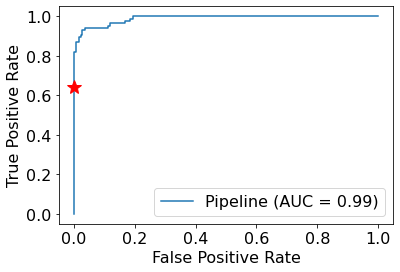

In [37]:
plot_roc_curve(pipe_lr, X_valid_fold, y_valid_fold);
plt.plot(cm[0,1]/(cm[0].sum()), cm[1,1]/(cm[1].sum()), '*r', markersize=15);

- Unlike the precision-recall curve, here the top-left is the best.
- Unlike the precision-recall curve, this curve is monotonic.
- The red star corresponds to the threshold of 0.5, which is used by `predict`.
  - The default threshold of 0.5 doesn't look very good here (more on this later).
- Note: there are functions `precision_recall_curve` and `roc_curve` (without the `plot_`) if you want to raw numbers.

(optional) Some extra explanation 

- If the threshold is 1, we always predict "negative".
  - the true positive rate is 0 because there are no true positives
  - the false positive rate is 0 because there are no false positives
  - this is the bottom-left point in the curve
- If the threshold is 0, we always predict "positive".
  - the true positive rate (recall) is 1 because we have identified all positive examples
  - the false positive rate is 1 because we have falsely identified all negatives as positive
  - this is the upper-right point in the curve

A popular metric is the area under the curve (AUC):

This animation shows what happens when you sweep the threshold.

![](https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/cutoff.gif)

### Q&A

(Pause for Q&A)

<br><br><br><br>

#### Area under the curve (AUC)

- AUC provides a single meaningful number for systems performance 
- AUC of 1.0 means perfect classification and AUC of 0.5 means random chance

In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
roc_auc_score(y_valid_fold, pipe_lr.predict_proba(X_valid_fold)[:,1])

0.9885166695730907

![](https://raw.githubusercontent.com/dariyasydykova/open_projects/master/ROC_animation/animations/ROC.gif)

Article claiming that precision-recall curves are better than ROC curves for imbalanced datasets: https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Addressing class imbalance (20 min)


#### Unbalanced training sets

- This typically refers to having many more examples of one class than another in one's training set.
- Our Credit Card Fraud dataset is unbalanced.

In [40]:
y_train.value_counts()

0    241672
1       413
Name: Class, dtype: int64

A lot of problems are coming from this class imbalance.

#### Do I want to address the problem?

- An important question is whether the class imbalance is a problem.
- Ask yourself, do I care more about false positives vs. false negatives?
- If not, then maybe it's fine to have a confusion matrix like we had:

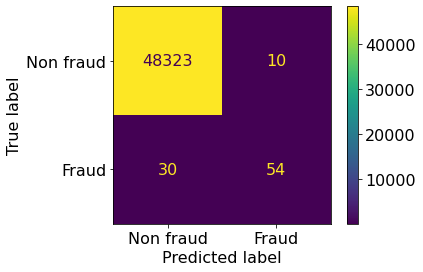

In [41]:
plot_confusion_matrix(pipe_lr, X_valid_fold, y_valid_fold, display_labels=['Non fraud', 'Fraud']);

#### Class weight

- Many sklearn classifiers have a parameter called `class_weight`.
- This allows you to specify that one class is more important than another.
- For example, maybe a false negative is 10x more problematic than a false positive. 

In [42]:
pipe_lr_1_10 = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight={1:10}))
]) 

- Instead of decreasing the threshold, we boost up all the scores from `predict_proba` and keep the threshold at 0.5.
- Either way we end up predicting more frauds.

In [43]:
pipe_lr_1_10.fit(X_train_fold, y_train_fold);

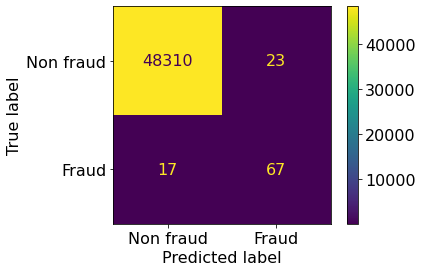

In [44]:
plot_confusion_matrix(pipe_lr_1_10, X_valid_fold, y_valid_fold, display_labels=['Non fraud', 'Fraud']);

- Notice we've predicted more Fraud this time (see the right column).
- This was like to saying "repeat every positive example 10x in the training set".
  - But repeating data would slow down the code, whereas this doesn't.
  - There are some fancier methods like SMOTE: see [paper](https://arxiv.org/pdf/1106.1813.pdf) and [code](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.over_sampling.SMOTE.html)
- A useful setting is `class_weight="balanced"`.
  - This sets the weights so that the classes are "equal".
  - You could also achieve this by setting the class weight manually by looking at the imbalance ratio.

In [45]:
pipe_lr_balanced = Pipeline([
    ('scale', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced'))
]) 

In [46]:
pipe_lr_balanced.fit(X_train_fold, y_train_fold);

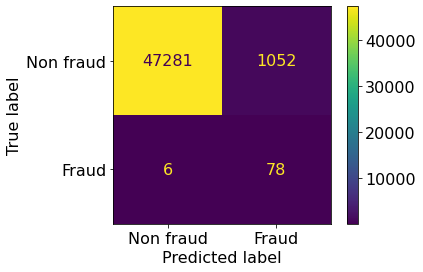

In [47]:
plot_confusion_matrix(pipe_lr_balanced, X_valid_fold, y_valid_fold, display_labels=['Non fraud', 'Fraud']);

## Q&A

(Pause for Q&A)

<br><br><br><br>

Important note: changing the class weight will **generally reduce accuracy**.

- The original model was trying to maximize accuracy.
- Now you're telling it to do something different.
- But that can be fine, accuracy isn't the only metric that matters.

In [48]:
pipe_lr.score(X_valid_fold, y_valid_fold)

0.9991738438978045

In [49]:
pipe_lr_balanced.score(X_valid_fold, y_valid_fold)

0.9781481710969288

- So what's going on here?
- Because there are so many more negative examples than positive, false positives affect accuracy much more than false negatives.
- Thus, precision matters a lot more than recall.
- So, the default method trades off a lot of recall for a bit of precision.
- This maximizes accuracy overall - but do we like it?

#### Why do I have imbalance?

- A very important question to ask yourself: "Why do I have a class imbalance?"
  - Is it because one class is much more rare than the other?
  - Is it because of my data collection methods?
- If it's the data collection, then that means _your deployment and training data come from different distributions_!
  - It's reasonable to use `class_weight` to try and fix this.
  - If it's just because one is more rare than the other, you need to ask whether you care about one type of error more than the other.
  - If so, it's again reasonable to use `class_weight` to address this.
  
But, if you answer "no" to both question, it may be fine to just ignore the class imbalance.

#### `class_weight` vs. changing your threshold

- Note that if you set `class_weight` because you care about one type of error more than the other, the output of `predict_proba` loses some of its meaning.
- It's not really true that you have a 90% chance of fraud for this example. 
- It's really 20%, but you don't want false negatives.
- What we're really doing is changing the threshold, but it's common to do it this way.
  - From a conceptual standpoint, I think it's more useful to think about changing the threshold.
- On the other hand, if you are using `class_weight` because it was harder to collect data for one of the classes, that is all fine.
- Be careful about how you interpret the probabilities in general, and extra careful when using `class_weight`!

### Q&A

(Pause for Q&A)

<br><br><br><br>

## Stratified Splits (5 min)

- A similar idea of "balancing" classes can be applied to data splits.
- For example, with cross-validation, there is also [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).
- From the documentation:

> This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

- In other words, if we have 10% negative examples in total, then each fold will have 10% negative examples.
- We have the same option in `train_test_split` with the `stratify` argument. 
- Is this a good idea? 
  - Well, it's no longer a random sample, which is probably theoretically bad, but not that big of a deal.
  - If you have many examples, it shouldn't matter as much.
  - It can be especially useful in multi-class, say if you have one class with very few cases.
  - In general, these are difficult questions.

In [ ]:
y_train.value_counts()

In [ ]:
y_train_fold.value_counts()

In [ ]:
y_valid_fold.value_counts()

We split into a certain ratio:

In [ ]:
len(y_valid_fold)/len(y_train)

But the number of frauds may not follow this exactly:

In [ ]:
(y_valid_fold==1).sum()/(y_train==1).sum()

- In this case, for a bigger dataset, it doesn't matter so much, but for small datasets it may.
- I don't have strong feelings about this, we won't use it much in this course.

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Scoring and hyperparameter tuning (5 min)

- When you use `GridSearchCV` or `RandomizedSearchCV` there is an option to enter a custom scoring function.
  - E.g. `scoring='roc_auc'`
- It's important to ask ourselves what scoring function we want to optimize.
- Optimizing recall might not make sense because you'll just try to predict fraud for everything.
- Something like F1 score, average precision score, or ROC AUC try to balance precision vs. recall.
  - But make sure you know whether your score is looking at `predict` or `predict_proba`.
- Speaking of which, what happens when you call `fit`? 
  - Answer: it optimizes some score that depends on the classifier, but usually related to accuracy.
  - However, `class_weight` can influence this.
- ROC AUC is generally considered a good score.

But note that the ROC curve and associated AUC score aren't affected so strongly by `class_weight`:

In [50]:
roc_auc_score(y_valid_fold, pipe_lr.predict_proba(X_valid_fold)[:,1])

0.9885166695730907

In [51]:
roc_auc_score(y_valid_fold, pipe_lr_balanced.predict_proba(X_valid_fold)[:,1])

0.9831859677849994

- Setting `class_weight` will shift all the probabilities toward one direction (e.g. Fraud).
- But it won't necessarily help you _separate_ the classes for a given threshold.

So, it's really up to you to decide things like:

- Do I plan to use the output of `predict_proba` in my application?
- What types of errors do I care about?
- What sort of threshold/`class_weight` do I want?

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Summary (5 min)

- Problem: "surely 99.9% accuracy is good?!"
- Solution: look at metrics beyond accuracy (e.g. confusion matrix)
- Problem: "I care more about false negatives than false positives"
- Solution: change probability threshold or use `class_weight`
- Problem: "I have a lot more negative examples in my dataset"
- Solution: ask yourself, is that really a problem? If so, use `class_weight` or something like SMOTE

So...

- In our standard workflow we should be asking ourselves these important questions above.
- We should keep an eye out for class imbalance.
- Don't always rely on `score` just because it's a default in sklearn!

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Evaluation metrics True/False (Piazza)

1. In medical diagnosis, false positives are more damaging than false negatives (assume "positive" means the person has a disease, "negative" means they don't).
2. In spam classification, false positives are more damaging than false negatives (assume "positive" means the email is spam, "negative" means they it's not).
3. In the medical diagnosis, high recall is more important than high precision.
4. If method A gets a higher accuracy than method B, that means its precision is also higher.
5. If method A gets a higher accuracy than method B, that means its recall is also higher.

<br><br><br><br><br><br><br><br><br>

**Do not read until after the True/False**

Method A - higher accuracy but lower precision

| neg  | pos |
|-----|------|
| 90  |  5     |
| 5  |   0    |

Method B - lower accuracy but higher precision

| neg | pos  |
|-----|------|
|  80  |  15     |
|  0  |  5    |

- Method A accuracy: 90/100
- Method B accuracy: 85/100
- Method A precision: 0
- Method B precision: 0.25

Note (and my previous mistake): the total true positives and total true negatives need to be the same for both methods, otherwise this whole thing doesn't make sense!

-------------

Method A - higher accuracy but lower recall

| neg | pos  |
|-----|------|
| 99| 0     |
|  1  |  0    |

Method B - lower accuracy but higher recall

| neg | pos  |
|-----|------|
| 0  | 99     |
|  0  |  1    |

- Method A accuracy: 99/100
- Method B accuracy: 1/100
- Method A recall: 0
- Method B recall: 1